In [1]:
import statsmodels.api as sm
from scipy import interpolate
from pandas import Series, DataFrame, Panel
from string import ascii_lowercase as letters
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from scipy.stats import wrapcauchy
import matplotlib.pyplot as plt
%matplotlib inline
%precision 4
plt.style.use('classic')
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial
np.random.seed(11)

In [2]:
plt.style.use('classic')

In [3]:
def rw2(n):# this gives samples from weibull(5,2)
    x=np.zeros(n)
    y=np.zeros(n)
    theta=[0]*n
    distance=[]
    theta[0]=wrapcauchy.rvs(c,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n):
        r=random.weibullvariate(alpha,beta)
        theta[i]=wrapcauchy.rvs(c,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x[i]=x[i-1]+r*math.cos(theta[i])
        y[i]=y[i-1]+r*math.sin(theta[i])
        distance.append(r)
    return(x,y,distance,theta)   
    
n=1000 #sample size
alpha=2 #scale
beta=5 #shape
c=0.9# shape parameter for Wrapped Cauchy distribution, it needs to be between 0 and 1
#data = rw2(n)
#x=data[0]
#y=data[1]
#r_original=data[2]# this is a vector of step-lengths
#theta_original=data[3]# this is a vector of headings
#t=range(0,n)

In [4]:
#very important
data=np.loadtxt("data_needed_all_time_steps")
x=data[0]
y=data[1]
t=range(0,n)

In [5]:
# my code pretty much starts here
time_step=0.1
t_new=np.arange(0,n-1,time_step)
f=interpolate.interp1d(t,x,kind='cubic')#,fill_value="extrapolate")
g=interpolate.interp1d(t,y,kind='cubic')#,fill_value="extrapolate") don't do this

In [6]:
x_new=f(t_new)
y_new=g(t_new)

In [7]:
#get the distances now and the angles
r=np.zeros(len(x_new)-1)# r the step-lengths
theta=np.zeros(len(x_new)-1)# theta the angle
new_data=np.zeros(len(x_new)-1)
for i in range(0,len(x_new)-1):
    r[i]=np.sqrt((x_new[i+1]-x_new[i])**2 + (y_new[i+1]-y_new[i])**2)
    theta[i]=math.atan2(y_new[i+1]-y_new[i], x_new[i+1]-x_new[i])
for i in range(0,len(x_new)-2):
    new_data[i]=theta[i+1]-theta[i]# save the difference in the heading
    if new_data[i]<0:
        new_data[i]=new_data[i]+2*math.pi    
data=r# save the step-lengths,have the same name as before in the MCMC sampler for the step-lengths
#new_data is the data that we introduce in the heading MCMC sampler
print(len(data))    
print(len(theta))
print(len(new_data))
new_data# it has a zero at the end
new_data=new_data[:-1]
#new_data without zero.
data=data[:-1]# change the step-lengths data as well
print(len(data))
print(len(new_data))# make sure they have the same lenghts

9989
9989
9989
9988
9988


In [8]:
def log_likelihood(x,a,b):# a is shape, b is scale
     return sum(dweibull.logpdf(x,scale=b,c=a))
def log_wclikelihood(x,a,b):
     return sum(wrapcauchy.logpdf(x,c=a,loc=b))# c is the shape parameter#MCMC sampler for the heading

In [9]:
# Now put them into the MCMC sampler, the second model is to be considered
import scipy.stats 
from scipy.stats import dweibull#MCMC sampler for the heading
# initial guess for theta(a) as array,these are shape(c) 
guess = 0.9
# Prepare storing MCMC chain as array of arrays.
A1 = [guess]
# define stepsize of MCMC.
stepsize = 0.0015 # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_wclikelihood(new_data,old_theta,0)#calculate the first log likelihood
# Metropolis-Hastings with 20,000 iterations.
for p in range(20000):
    new_theta = old_theta + stats.norm(0, stepsize).rvs() 
    #add the restraints on new_theta
    if new_theta<0 or new_theta>1: 
        continue
    new_loglik = log_wclikelihood(new_data,new_theta,0)
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A1.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A1.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A1.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))

#0.00050

Acceptance rate = 0.3436


0.9842030464223529
0.9845155373668708
19001


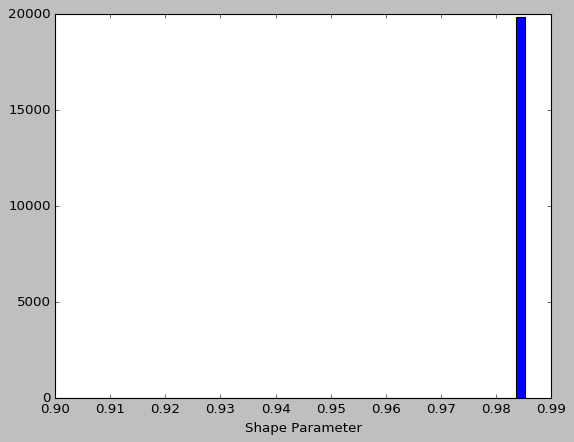

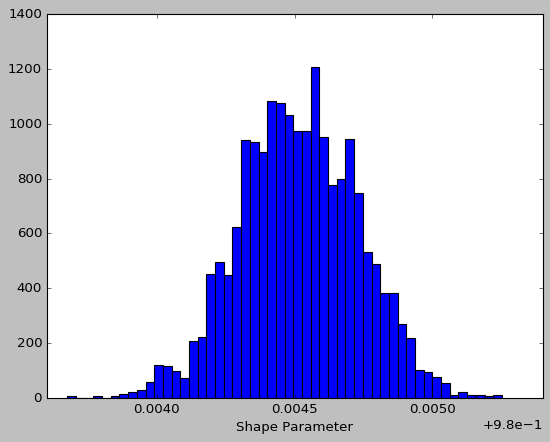

In [10]:
print(np.mean(A1))
print(np.mean(A1[1000:]))# burn in 1000
plt.hist(A1,bins=50)
B1=np.array(A1[1000:])
print(len(B1))
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B1,bins=50)
plt.xlabel("Shape Parameter")
plt.show()


In [11]:
#MCMC sampler for the step-lengths
import scipy.stats as stats
import numpy as np
# initial guess for theta(a and b) as array.
guess = [5.0,2.0]
# Prepare storing MCMC chain as array of arrays.
A2 = [guess]
# define stepsize of MCMC.
stepsizes = [0.0050,0.0050] # array of stepsizes
accepted  = 0.0
old_theta=guess# define initial values for theta 
old_loglik = log_likelihood(data,old_theta[0],old_theta[1])#calculate the first log likelihood
# Metropolis-Hastings with 25,000 iterations.
for p in range(25000):
    # Suggest new candidate from Gaussian proposal distribution.
    new_theta = old_theta + stats.norm(0, stepsizes).rvs() 
    #add the restraints on new_theta
    if new_theta[0]<0 or new_theta[1]<0: 
        continue
    new_loglik = log_likelihood(data,new_theta[0],new_theta[1])
    # Accept new candidate in Monte-Carlo fashing.
    if (new_loglik > old_loglik):
        A2.append(new_theta)
        accepted = accepted + 1.0  # monitor acceptance
        old_loglik=new_loglik
        old_theta=new_theta
    else:
        u = random.uniform(0.0,1.0)
        if (u < math.exp(new_loglik - old_loglik)):
            A2.append(new_theta)
            accepted = accepted + 1.0  # monitor acceptance
            old_loglik=new_loglik
            old_theta=new_theta
        else:
            A2.append(old_theta)
print("Acceptance rate = "+str(accepted/10000.0))
#0.0015

Acceptance rate = 0.3202


25001
4.476721173557733
0.20256991311299447


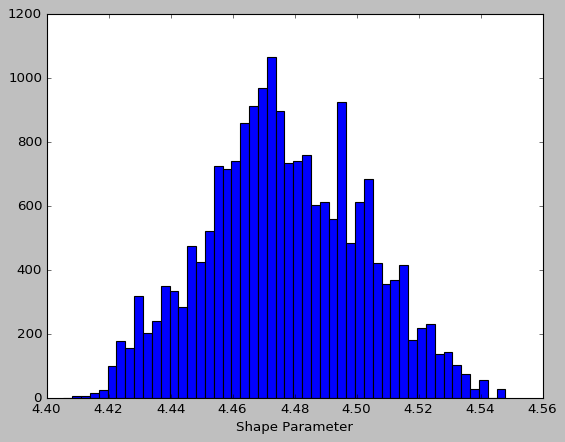

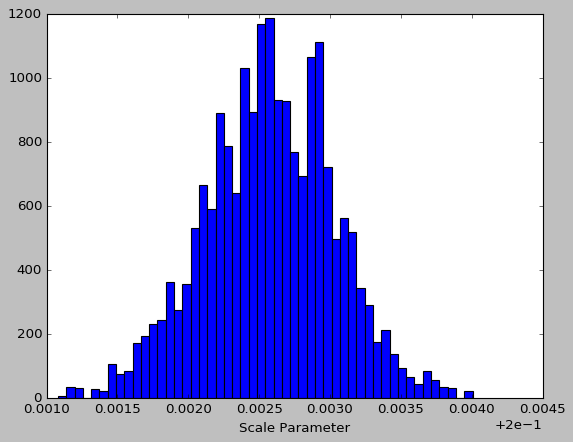

In [12]:
print(len(A2))
B2=np.array(A2[5000:])#burn-in 1000
shape_mean=np.mean(B2[:,0])
scale_mean=np.mean(B2[:,1])
print(shape_mean)
print(scale_mean)
plt.hist(B2[:,0],bins=50)
plt.xlabel("Shape Parameter")
plt.show()
plt.hist(B2[:,1],bins=50)
plt.xlabel("Scale Parameter")
plt.show()

In [14]:
# Weibull
shape_parameters=B2[:,0]
scale_parameters=B2[:,1]
# select every 10th observation
shape_parameters_need=shape_parameters[::10][:-101]# same length now
scale_parameters_need=scale_parameters[::10][:-101]
#Wrapped Cauchy
shapewc_parameters=B1
shapewc_parameters_need=B1[::10][:-1]
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))
#made some changes here

1900
1900
1900


In [15]:
# now changing the parameters and n with the ones that I got
def rw2_change(n_change,alpha_change,beta_change,c_change):# this gives samples from the inference model
    x_change=np.zeros(n_change)
    y_change=np.zeros(n_change)
    theta=np.zeros(n_change)
    distance=[]
    theta[0]=wrapcauchy.rvs(c_change,loc=0,size=1)
    if theta[0]>2*math.pi:
            theta[0] = theta[0] - 2* math.pi
    if theta[0]<0:
            theta[0] = theta[0] + 2* math.pi
    for i in range(1,n_change):
        r=random.weibullvariate(alpha_change,beta_change)
        theta[i]=wrapcauchy.rvs(c_change,loc=theta[i-1],size=1)# c is the shape parameter
        if theta[i]>2*math.pi:
            theta[i] =theta[i] - 2* math.pi
        if theta[i]<0:
            theta[i] = theta[i] + 2* math.pi
        x_change[i]=x_change[i-1]+r*math.cos(theta[i])
        y_change[i]=y_change[i-1]+r*math.sin(theta[i])
        distance.append(r)# save the distances r for the mcmc sampler
    return [x_change,y_change,distance,theta]   
    
n_change=len(new_data) #int(input("how many steps?"))
alpha_change=scale_parameters_need#int(input("what's the scale?"))
beta_change=shape_parameters_need #int(input("what's the shape?"))
c_change=shapewc_parameters_need# float(input("What's the shape parameter for the wrapped Cauchy?"))# this needs to be between 0 and 1
#x_change = np.array(rw2_change(n_change)[0])
#y_change=np.array(rw2_change(n_change)[1])
#data_change=np.array(rw2_change(n_change)[2])
#theta_change=np.array(rw2_change(n_change)[3])
#the previous code

In [16]:
n_change
# make this smaller
# I went for 1000
# So basically I have a big list, the length is the number of parameters and each entry has 1000 elements

9988

In [17]:
print(scale_parameters_need)
print(shape_parameters_need)
print(shapewc_parameters_need)
print(n_change)

[0.2028 0.2019 0.2032 ... 0.2029 0.2028 0.2028]
[4.5095 4.5013 4.5036 ... 4.4526 4.4716 4.4716]
[0.9845 0.9845 0.9845 ... 0.9845 0.9842 0.984 ]
9988


In [18]:
print(len(shapewc_parameters_need))
print(len(scale_parameters_need))
print(len(shape_parameters_need))
#make them the same size, check again

1900
1900
1900


In [19]:
data_change=list(np.zeros(len(shape_parameters_need)))
theta_change=list(np.zeros(len(shapewc_parameters_need)))

In [21]:
#if you want to make them the same size
print(len(theta_change))
#print(len(theta_original))
#print(len(r_original))
print(len(data_change))
#Let's go to 999 then
#theta_change=theta_change[:999]
#theta_original=theta_original[:999]
#data_change=data_change[:999]
#shape_parameters_need=shape_parameters_need[:999]
#scale_parameters_need=scale_parameters_need[:999]
#shapewc_parameters_need=shapewc_parameters_need[:999]

1900
1900


In [22]:
for i in range(len(shape_parameters_need)):
                     data_change[i]=np.array(rw2_change(1000,alpha_change[i],beta_change[i],c_change[i])[2])#the distances

In [23]:
for i in range(len(shape_parameters_need)):
                     theta_change[i]=np.array(rw2_change(1000,alpha_change[i],beta_change[i],c_change[i])[3])#the angles

In [24]:
# the mean of the inferred parameters
mean_shape_weibullparameter=np.mean(shape_parameters)
mean_scale_weibullparameter=np.mean(scale_parameters)
mean_shape_wcparameter=np.mean(shapewc_parameters)
print(mean_shape_weibullparameter)
print(mean_scale_weibullparameter)
print(mean_shape_wcparameter)

4.476721173557733
0.20256991311299447
0.9845155373668708


In [25]:
#calculate T_y for the downsampled data i.e. new data obtained after interpolation
T_y_weibull=log_likelihood(data,mean_shape_weibullparameter,mean_scale_weibullparameter)/len(data)
T_y_wc=log_wclikelihood(new_data,mean_shape_wcparameter,0)/len(new_data)
# T_y in total
T_y=T_y_weibull+T_y_wc
T_y


2.7545403224312888

In [37]:
# investigate why the red line it's on the right hand side
print(T_y_weibull)
print(T_y_wc)


0.948661050440003
1.8058792719912857


In [26]:
print(len(data_change))
print(len(theta_change))
print(len(data))
print(len(new_data))

1900
1900
9988
9988


In [27]:
#data_change-step-lengths after the change of the parameters after inference
#theta_change-headings after the change of the parameters after inference

In [28]:
T_y_rep_weibull=np.zeros(len(shape_parameters_need))
for i in range(len(shape_parameters_need)):
    T_y_rep_weibull[i]=log_likelihood(data_change[i],shape_parameters_need[i],scale_parameters_need[i])/len(data_change[i])
    

In [29]:
print(len(T_y_rep_weibull))
#T_y_rep_weibull

1900


In [44]:
# further investigate, log likelihood for the step-lengths model
print(T_y_rep_weibull)# log likelihood for the replicate data
print(T_y_weibull)# log likelihood for the dataset 1


[0.9957 0.9727 0.9826 ... 0.9532 0.9549 0.9537]
0.948661050440003


In [30]:
count_zeros=0
for i in range(len(shape_parameters_need)):
    if T_y_rep_weibull[i]==0:
        count_zeros+=1
count_zeros

0

In [31]:
T_y_rep_wc=np.zeros(len(shapewc_parameters_need))
for i in range(len(shapewc_parameters_need)):
    T_y_rep_wc[i]=log_wclikelihood(theta_change[i],shapewc_parameters_need[i],0)/len(theta_change)


In [46]:
# Further investigate, here is the reason. the log likelihood for the replicate data for the turning angles is much much lower
print(T_y_rep_wc)
print(T_y_wc)


[-2.9405 -2.9939 -3.1103 ... -2.496  -2.9057 -2.4076]
1.8058792719912857


In [57]:
print(new_data)# turning angles dataset 1
print(np.mean(new_data))
print(0.9845)# mean_shape_wc_parameter dataset 1
print(shapewc_parameters_need)# shape parameters dataset 2 


[6.2701 6.2691 6.2682 ... 6.2526 6.2513 6.2504]
3.1690089612162935
0.9845
[0.9845 0.9845 0.9845 ... 0.9845 0.9842 0.984 ]


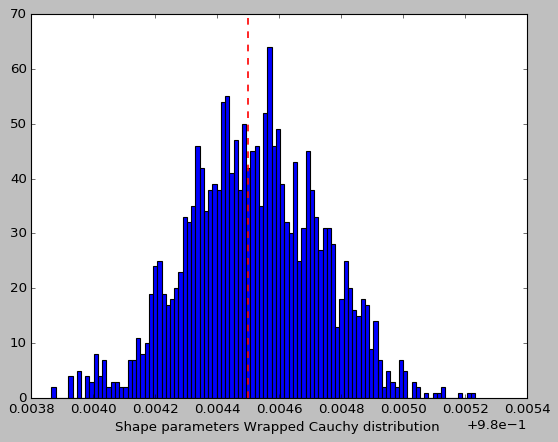

In [80]:
plt.hist(shapewc_parameters_need,bins=100)
plt.xlabel("Shape parameters Wrapped Cauchy distribution ")
plt.axvline(0.9845,linestyle='dashed', linewidth=1.5,color='red')
plt.show()

In [58]:
print(np.mean(theta_change))

3.1548970289338554


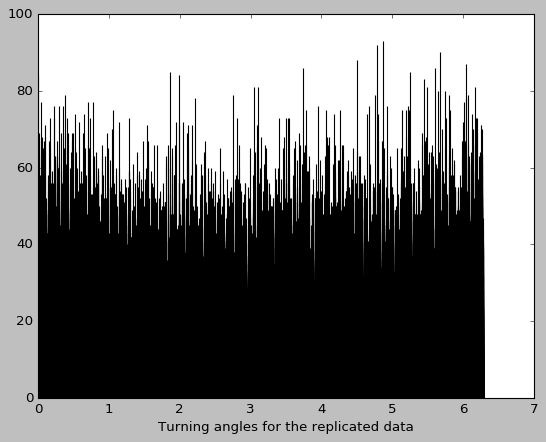

In [81]:
plt.hist(theta_change,bins=100)
plt.xlabel("Turning angles for the replicated data")
plt.show()

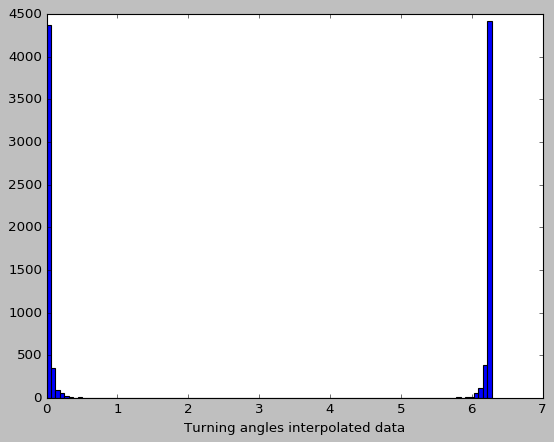

In [73]:
plt.hist(new_data,bins=100)
plt.xlabel('Turning angles interpolated data')
plt.show()

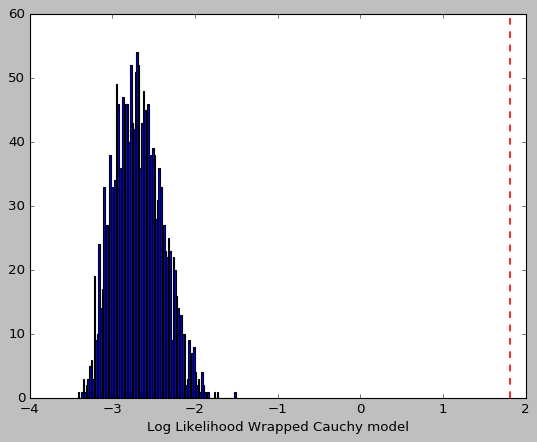

In [69]:
plt.hist(T_y_rep_wc,bins=100)
plt.axvline(T_y_wc,linestyle='dashed', linewidth=1.5,color='red')
plt.xlabel("Log Likelihood Wrapped Cauchy model")
plt.show()

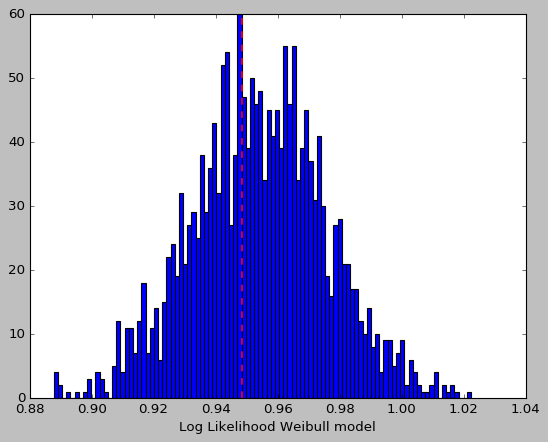

In [68]:
plt.hist(T_y_rep_weibull,bins=100)
plt.axvline(T_y_weibull,linestyle='dashed', linewidth=1.5,color='red')
plt.xlabel("Log Likelihood Weibull model")
plt.show()

In [56]:
np.savetxt("turning_angles_dataset_2_time_0.1",theta_change)

In [32]:
count_zeros=0
for i in range(len(shapewc_parameters_need)):
    if T_y_rep_wc[i]==0:
        count_zeros+=1
count_zeros

0

In [33]:
print(len(T_y_rep_wc))
#T_y_rep_wc

1900


In [34]:
T_y_rep=T_y_rep_weibull+T_y_rep_wc   
T_y_rep

array([-1.9448, -2.0212, -2.1277, ..., -1.5428, -1.9509, -1.4539])

In [35]:
count=0
for i in range(len(shape_parameters_need)):
    if T_y_rep[i]>T_y:
        count+=1
print(count)
print(len(shape_parameters_need))
ppp_value=count/len(shape_parameters_need)
print(ppp_value)


0
1900
0.0


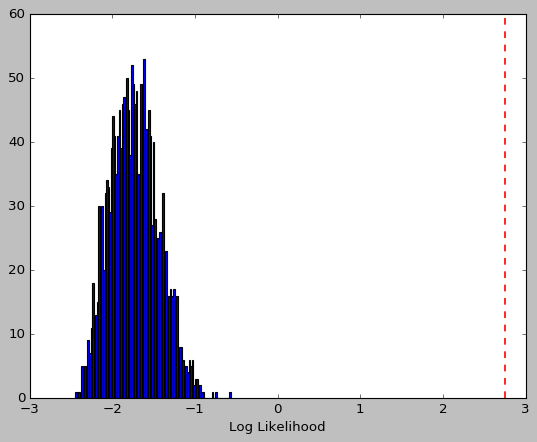

In [70]:
plt.hist(T_y_rep,bins=100)
plt.axvline(T_y,linestyle='dashed', linewidth=1.5,color='red')
plt.xlabel('Log Likelihood')
plt.show()
